<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/Bayesian_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.7.10


In [1]:
!pip install -q git+https://github.com/brendanhasz/probflow.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

import probflow as pf

# Additional Preprocessing and functions

In [10]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[[0,1]], axis = 1)
train_idx = pd.read_csv('/content/drive/MyDrive/data/mylist.csv')

In [11]:
train = claim.iloc[train_idx.iloc[:,0],:]
test = claim.drop(train_idx.iloc[:,0], axis = 0)

In [12]:
# target
N_train = train.ClaimNb.to_numpy(dtype = 'float32')
N_test = test.ClaimNb.to_numpy(dtype = 'float32')

# exposure
v_train = train.Exposure.to_numpy(dtype = 'float32')
v_test = test.Exposure.to_numpy(dtype = 'float32')

lv_train = np.log(v_train)
lv_test = np.log(v_test)


# exposure is included in features
x_train = train.drop(['ClaimNb'], axis = 1).to_numpy(dtype = 'float32')
x_test = test.drop(['ClaimNb'], axis = 1).to_numpy(dtype = 'float32')

In [154]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviance')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance

# deviance according to Wuthrix
def deviance(lambd, v, N, homogenous = False):
  log = 0
  NN = 0
  if homogenous is True:
    Mu = np.asarray(lambd * v)
  else:
    Mu = np.asarray(lambd)
  for n, mu  in zip(N, Mu):
    if n != 0:
      log += n * np.log(n / mu)
      NN += n
  result = 2 * (np.sum(Mu) - NN + log)/ N.shape[0]
  return result

def prediction(model):
  training = model.predict(x_train).flatten()
  testing = model.predict(x_test).flatten()
  print('Deviancia na trenovacej mnozine je: ', deviance(training, v_train, N_train))
  print('Deviancia na testovacej mnozine je: ', deviance(testing, v_test, N_test))
  print('Priemerna frekvencia na testovacej mnozine: ', testing.sum() / v_test.sum())

def poisson_deviance(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  return 2 * K.mean(y_pred - y_true + y_true * math_ops.log((y_true + K.epsilon()) /(y_pred + K.epsilon())), axis=-1)
 

In [14]:
x_train.shape

(610212, 38)

# Bayesian model

In [87]:
from probflow.utils.casting import to_tensor
tf.nn.relu(x_test @ t())


[38, 5]

In [27]:
p = pf.Parameter([37, 10])
(x_test[:,1::] @ p()).shape
boha = exposition

TensorShape([67801, 10])

In [22]:
tf.reshape(tf.convert_to_tensor(v_test), shape = [1,-1]).shape

TensorShape([1, 67801])

In [99]:
x_test[5:15,0]

array([0.9 , 0.81, 0.14, 0.06, 0.84, 0.78, 0.37, 0.11, 0.07, 0.07],
      dtype=float32)

In [140]:
blorian = exposition()
tf.reshape(blorian(x_test[5:15]), [-1,1]).shape


TensorShape([10, 1])

In [131]:
gimli = DenseNetwork([38, 20,10,1])
gimli(x_test[5:15])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.28934756],
       [0.29485115],
       [0.30862892],
       [0.29498875],
       [0.30029207],
       [0.31465688],
       [0.31189787],
       [0.31663337],
       [0.28586006],
       [0.2865606 ]], dtype=float32)>

In [139]:

gimli(x_test[5:15]) * tf.reshape(blorian(x_test[5:15]), [-1,1])


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.26041278],
       [0.23882943],
       [0.04320805],
       [0.01769933],
       [0.25224534],
       [0.24543236],
       [0.11540221],
       [0.03482967],
       [0.0200102 ],
       [0.02005924]], dtype=float32)>

In [115]:
0.07*0.1519

0.010633000000000002

In [198]:
class FirstLayer(pf.Module):
    def __init__(self, d_in: int, d_out: int):
        self.w = pf.Parameter([d_in - 1, d_out])
        self.b = pf.Parameter([1, d_out])

    def __call__(self, x):
        x = x[:,1::]
        return x @ self.w() + self.b()


class exposition(pf.Module):
    def __init__(self):
        self.w = pf.Parameter() # must be some parameter even if not used
    def __call__(self, x):
        y = tf.convert_to_tensor(x[:,0])
        y = tf.reshape(y, [-1,1])
        return y

class DenseLayer(pf.Module):

    def __init__(self, d_in: int, d_out: int):
        self.w = pf.Parameter([d_in, d_out])
        self.b = pf.Parameter([1, d_out])

    def __call__(self, x):
        return x @ self.w() + self.b()


class DenseNetwork(pf.Module):

    def __init__(self, dims):
        Nl = len(dims) - 1 #number of layers
        self.layers = [FirstLayer(dims[0], dims[1])]
        self.layers += [DenseLayer(dims[i], dims[i+1]) for i in range(1, Nl)]
        self.activations = (Nl - 1) * [tf.nn.relu]
        self.activations += [tf.math.softplus] # toto zkladnuje vstup do argumentu pois rozdelenia

    def __call__(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        #x = self.last_layer(x)
        #x = self.activations[len(self.activations) - 1](x)
        return x


class predictor(pf.Module):
  
    def __init__(self, dims):
      self.network = DenseNetwork(dims)
      self.offset = exposition()
    def __call__(self,x):
        return self.network(x) * self.offset(x)

class DenserRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.net = predictor(dims)

    def __call__(self, x):
        return pf.Poisson(self.net(x))

class PoissonRegression(pf.ContinuousModel):

    def __init__(self, d_in):
        self.net = pf.Sequential([
            pf.Dense(d_in, 20),
            tf.nn.relu,
            pf.Dense(20, 16),
            tf.nn.relu,
            pf.Dense(16, 10),
            tf.nn.relu,
            pf.Dense(10, 1),
            tf.math.softplus
        ])
        
    def __call__(self, x):
        return pf.Poisson(self.net(x))

In [199]:
bayes_second = DenserRegression([38,32,16,8,1])
#bayes_second = PoissonRegression_tanh(38)

In [ ]:
b

In [200]:
# Record the ELBO
monitor_elbo = pf.MonitorELBO()

# Anneal the learning rate from ~2e-4 to ~0
lr_scheduler = pf.LearningRateScheduler(lambda e: 2e-4-2e-6*e)

# List of callbacks
callbacks = [monitor_elbo]

In [201]:
%%time
bayes_second.fit(x_train, N_train, epochs = 50, batch_size=2000, callbacks=callbacks, num_workers=4, eager = True)

CPU times: user 17min 6s, sys: 46min 13s, total: 1h 3min 19s
Wall time: 44min 25s


In [ ]:
class PoissonRegression_tanh(pf.Model):

    def __init__(self, d_in):
        self.net = pf.Sequential([
            pf.Dense(d_in, 32),
            tf.nn.tanh,
            pf.Dense(32, 20),
            tf.nn.tanh,
            pf.Dense(20, 10),
            tf.nn.tanh,
            pf.Dense(10, 1),
            tf.math.softplus
        ])
        
    def __call__(self, x):
        return pf.Poisson(self.net(x))

In [203]:
prediction(bayes_second)

Deviancia na trenovacej mnozine je:  0.32722929077495455
Deviancia na testovacej mnozine je:  0.3362374390858264
Priemerna frekvencia na testovacej mnozine:  0.094369836


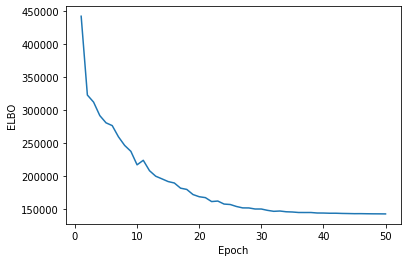

In [204]:
monitor_elbo.plot()
# pozret v plt.plot ako priblizit, priblizit to blizsie ako sa to meni

In [209]:
first = bayes_first.predict(x_test)
second = bayes_second.predict(x_test)

In [168]:
first

array([[0.10875688],
       [0.00598985],
       [0.06289923],
       ...,
       [0.00264336],
       [0.0014286 ],
       [0.0006656 ]], dtype=float32)

In [196]:
bayes_first.predictive_sample(x_test[5666], n = 1000).mean()

0.052

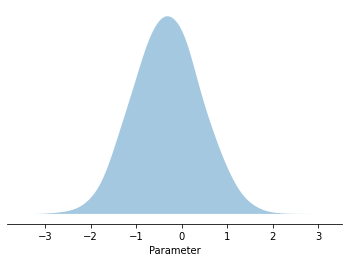

In [186]:
bayes_first.parameters[5].posterior_plot()

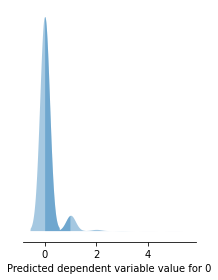

In [212]:

bayes_first.pred_dist_plot(x_test[6888], ci=0.95,
                     individually=True, cols=2)



In [210]:

results = pd.DataFrame()
results['first'] = first.flatten()
results['second'] = second.flatten()
#results['third'] = third.flatten()

In [42]:
len(first)

67800

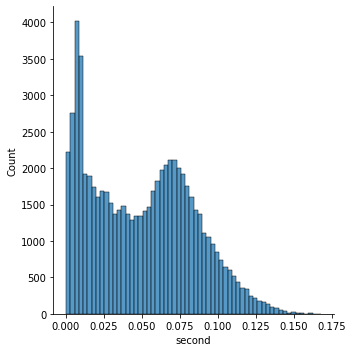

In [211]:
sns.displot(results, x = 'second')

In [ ]:
bayes_first.predictive_sample(x_test[2,:])

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [

In [ ]:
bayes_second.predictive_sample(x_test).shape

(1000, 67801, 1)

In [ ]:
#bayes_first.posterior_plot(params= bayes_first.parameters[1], cols = 4)
bayes_first.prob(x_test_full,N_test)

TypeError: ignored

In [ ]:
N_test

12        1
22        1
35        1
48        1
57        1
         ..
677928    0
677930    0
677950    0
677981    0
677999    0
Name: ClaimNb, Length: 67801, dtype: int64

In [ ]:
prediction(bayes_first)

Deviancia na trenovacej mnozine je:  0.3206213978682769
Deviancia na testovacej mnozine je:  0.3304042294180813


In [ ]:
bayes_first.save('/content/drive/MyDrive/models_diplom/bayes_20.pfm')

RuntimeError: ignored